In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [73]:
# データの読み込み
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [74]:
# データの確認
test.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [75]:
# ラベルを数値に変える
from sklearn.preprocessing import LabelEncoder

for i in range(train.shape[1]):
    if train.iloc[:,i].dtypes == object:
        lbl = LabelEncoder()
        lbl.fit(list(train.iloc[:,i].values) + list(test.iloc[:,i].values))
        train.iloc[:,i] = lbl.transform(list(train.iloc[:,i].values))
        test.iloc[:,i] = lbl.transform(list(test.iloc[:,i].values))

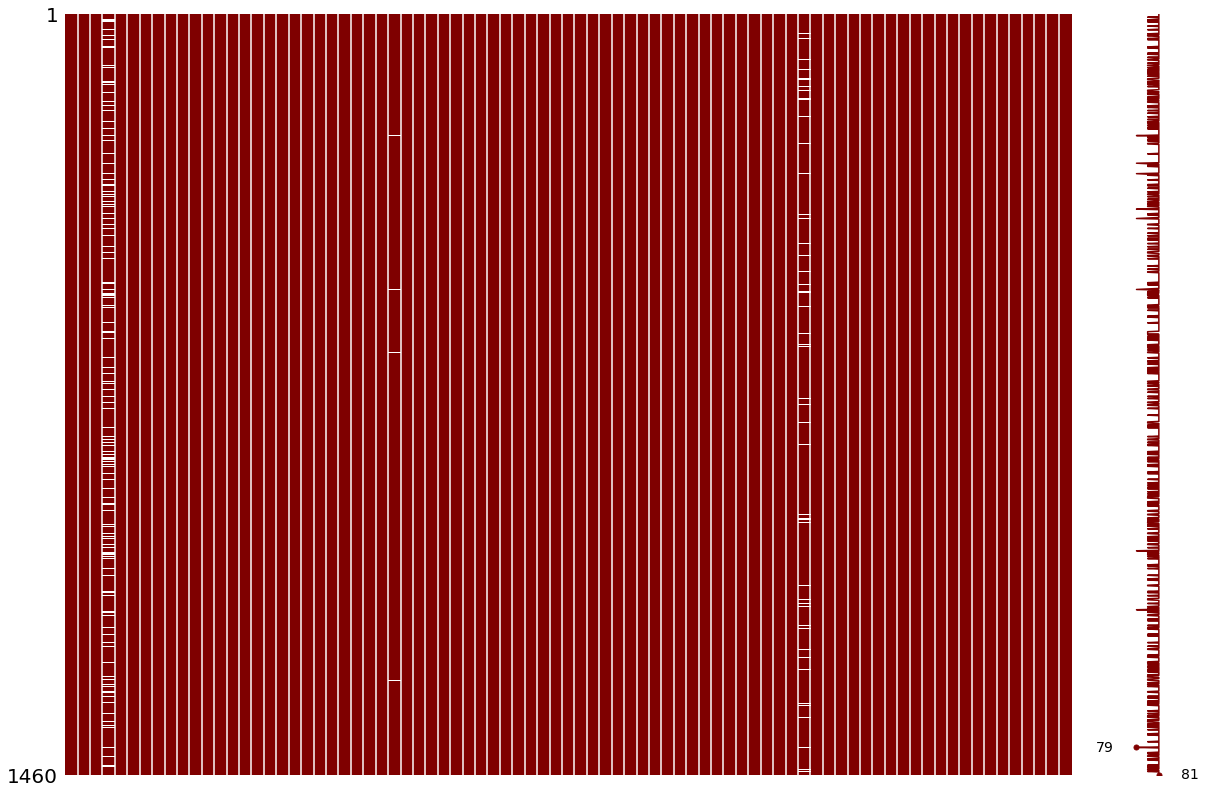

In [77]:
# 欠損地を確認
import missingno as msno
msno.matrix(df=train, figsize=(20,14), color=(0.5,0,0))

In [78]:
# IDをとっておく
train_ID = train['Id']
test_ID = test['Id']

# データを取っておく
y_train = train['SalePrice']
X_train = train.drop(['Id','SalePrice'], axis=1)
X_test = test.drop('Id', axis=1)

# 欠損地を中央値で代用する
Xmat = pd.concat([X_train, X_test])
Xmat = Xmat.drop(['LotFrontage','MasVnrArea','GarageYrBlt'], axis=1)
Xmat = Xmat.fillna(Xmat.median())

# 欠損が多いものは削除する
X_train = X_train.drop(['LotFrontage','MasVnrArea','GarageYrBlt'], axis=1)
X_train = X_train.fillna(Xmat.median())

# SFをまとめる
X_train['TotalSF'] = X_train['TotalBsmtSF'] + X_train['1stFlrSF'] + X_train['2ndFlrSF']

# テストデータも同様に
X_test = X_test.drop(['LotFrontage','MasVnrArea','GarageYrBlt'], axis=1)
X_test = X_test.fillna(Xmat.median())
X_test['TotalSF'] = X_test['TotalBsmtSF'] + X_test['1stFlrSF'] + X_test['2ndFlrSF']

/Users/kotaro/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


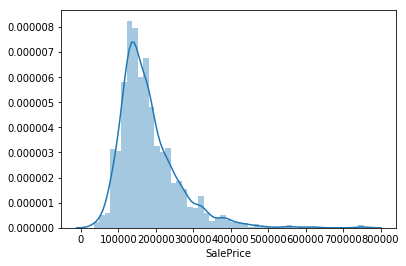

In [79]:
# 正規分布がチェック
ax = sns.distplot(y_train)
plt.show()

/Users/kotaro/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


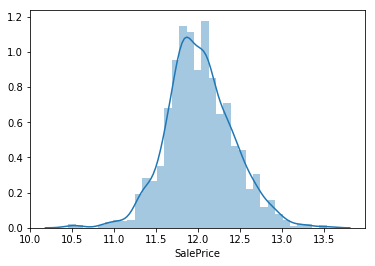

In [80]:
# 対数を取り正規分布にする
y_train = np.log(y_train)
ax = sns.distplot(y_train)
plt.show()

Training done using Random Forest


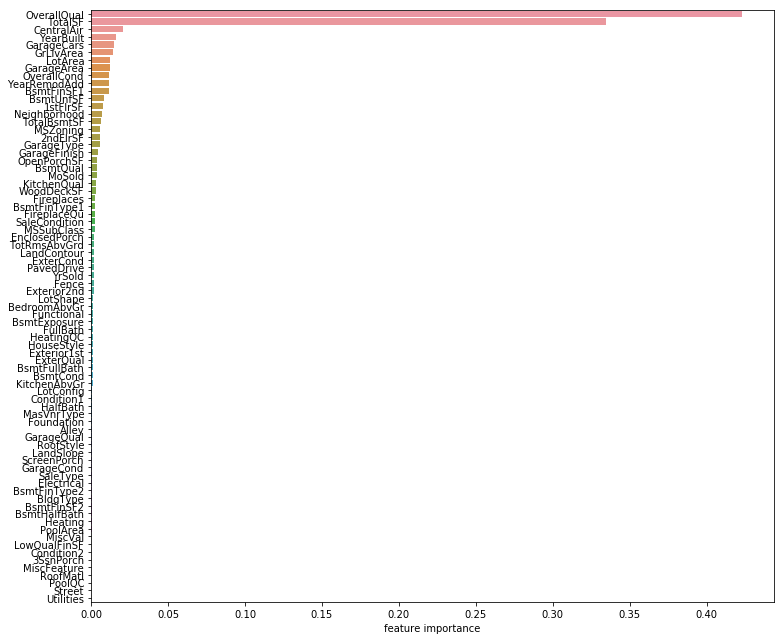

In [81]:
# どの特徴量が重要か
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=80, max_features='auto')
rf.fit(X_train, y_train)
print('Training done using Random Forest')

ranking = np.argsort(-rf.feature_importances_)
f, ax = plt.subplots(figsize=(11, 9))
sns.barplot(x=rf.feature_importances_[ranking], y=X_train.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

In [82]:
# 上位30の特徴量を使う
X_train = X_train.iloc[:,ranking[:30]]
X_test = X_test.iloc[:,ranking[:30]]

In [83]:
# 上位2つのインターセクションをとる
X_train["Interaction"] = X_train["TotalSF"]*X_train["OverallQual"]
X_test["Interaction"] = X_test["TotalSF"]*X_test["OverallQual"]

/Users/kotaro/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


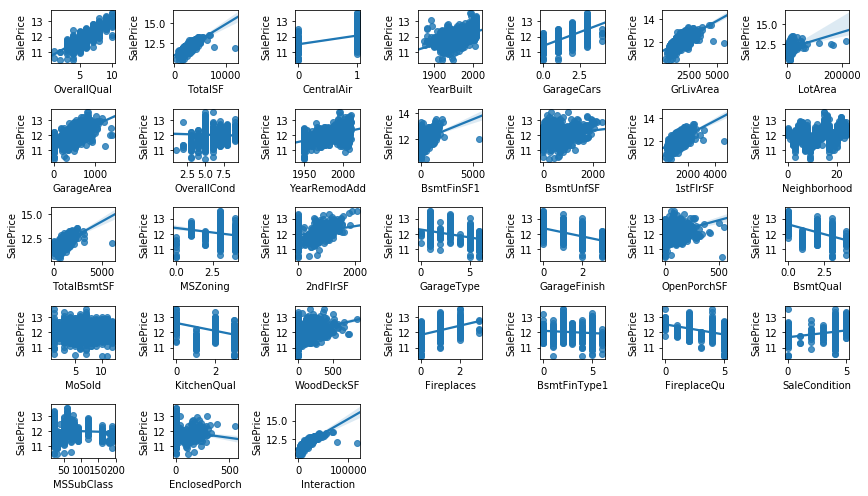

In [86]:
# それぞれの特徴量の相関を見る
fig = plt.figure(figsize=(12,7))
for i in np.arange(31):
    ax = fig.add_subplot(5,7,i+1)
    sns.regplot(x=X_train.iloc[:,i], y=y_train)

plt.tight_layout()
plt.show()

In [87]:
# 外れ値を外す
Xmat = X_train

Xmat['SalePrice'] = y_train
Xmat = Xmat.drop(Xmat[(Xmat['TotalSF']>5000) & (Xmat['SalePrice']<12.5)].index)
Xmat = Xmat.drop(Xmat[(Xmat['GrLivArea']>4000) & (Xmat['SalePrice']<13)].index)

y_train = Xmat['SalePrice']
X_train = Xmat.drop(['SalePrice'], axis=1)

(1460, 31)


(1458, 31)

/Users/kotaro/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


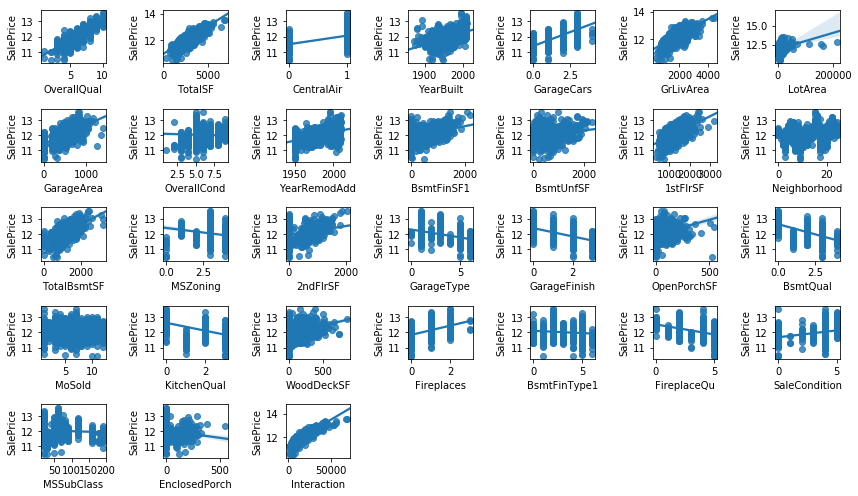

In [88]:
fig = plt.figure(figsize=(12,7))
for i in np.arange(31):
    ax = fig.add_subplot(5,7,i+1)
    sns.regplot(x=X_train.iloc[:,i], y=y_train)

plt.tight_layout()
plt.show()

In [89]:
# XGBoostを利用する
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

print("Parameter optimization")
xgb_model = xgb.XGBRegressor()
reg_xgb = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, verbose=1)
reg_xgb.fit(X_train, y_train)

Parameter optimization
Fitting 3 folds for each of 9 candidates, totalling 27 fits


/Users/kotaro/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/kotaro/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/kotaro/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/kotaro/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/kotaro/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/xgboost/core.py:58

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 4, 6], 'n_estimators': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [90]:
# 対数を取って正規表現にしたので戻す
y_pred = np.exp(reg_xgb.predict(X_test))

# 提出
submission = pd.DataFrame({
    "Id": test_ID,
    "SalePrice": y_pred
})
submission.to_csv('houseprice.csv', index=False)

In [96]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f ./houseprice.csv -m "Message"

100%|██████████████████████████████████████| 21.1k/21.1k [00:12<00:00, 1.71kB/s]
Successfully submitted to House Prices: Advanced Regression Techniques